In [4]:
import obspy 
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from obspy.geodetics.base import gps2dist_azimuth as epi
from obspy.geodetics import kilometer2degrees as k2d
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt,rotate_zne_lqt
import numpy as np
client = Client('IRIS')
from obspy.taup.taup_create import build_taup_model
build_taup_model('/Users/tong/iasp91_modified.tvel')
tpmodel = TauPyModel(model='iasp91_modified')

Building obspy.taup model for '/Users/tong/iasp91_modified.tvel' ...


In [5]:
t1= UTCDateTime('201502111857')
net = 'II'
sta = 'KIV'
loc = '00'
cha = 'BH?'
phase = ['SKS']
align = '12Z' #'NEZ' 
new_sr=10
fmin = 1/25
fmax = 1/8


In [6]:
Cata = client.get_events(starttime=t1, endtime=t1+60, minmagnitude=6)
print(Cata)
evtime= Cata[0].origins[0].time
evlon= Cata[0].origins[0].longitude
evlat= Cata[0].origins[0].latitude
depth= Cata[0].origins[0].depth/1000
mag  = Cata[0].magnitudes[0].mag


1 Event(s) in Catalog:
2015-02-11T18:57:20.460000Z | -23.065,  -66.662 | 6.7 MW


In [7]:
inventory = client.get_stations(network=net, station=sta,
                                starttime=evtime ,
                                endtime=evtime+30*60)

stlat = inventory[0][0].latitude
stlon = inventory[0][0].longitude
stele = inventory[0][0].elevation


In [8]:
ori_st = client.get_waveforms(net, sta, loc, cha, evtime, evtime+30*60)
print(ori_st)

3 Trace(s) in Stream:
II.KIV.00.BH1 | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.419500Z | 20.0 Hz, 36000 samples
II.KIV.00.BH2 | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.419500Z | 20.0 Hz, 36000 samples
II.KIV.00.BHZ | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.419500Z | 20.0 Hz, 36000 samples


In [12]:
epi_dist, azi, baz = epi(evlat, evlon, stlat, stlon)
epi_dist /= 1000
gac = k2d(epi_dist)

arrivals = tpmodel.get_travel_times(distance_in_degree=gac, source_depth_in_km=depth, phase_list=phase)
arrival = arrivals[0]
arr_time= arrival.time
arr_slow = arrival.ray_param_sec_degree/111
arr_inc = arrival.incident_angle
print(arr_inc)

1.91871337991


In [13]:
st = ori_st.copy()
st.filter('lowpass', freq=0.5*new_sr, corners=2, zerophase=True)
st.resample(new_sr, no_filter=False)
st.detrend('linear')
st.detrend('demean')

fil_st = st.copy()
fil_st.filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
if align == '12Z':
    st.select(component='2')[0].stats.channel = st.select(component='2')[0].stats.channel[:-1]+'E'
    st.select(component='1')[0].stats.channel = st.select(component='1')[0].stats.channel[:-1]+'N'
    trE = fil_st.select(component='2')[0].copy()
    trN = fil_st.select(component='1')[0].copy()
    trZ = fil_st.select(component='Z')[0].copy()
    trN.stats.channel = trN.stats.channel[:-1] + 'N'
    trE.stats.channel = trE.stats.channel[:-1] + 'E'
elif align == 'NEZ':
    trE = fil_st.select(component='E')[0].copy()
    trN = fil_st.select(component='N')[0].copy()
    trZ = fil_st.select(component='Z')[0].copy()

In [11]:
st

3 Trace(s) in Stream:
II.KIV.00.BHN | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples
II.KIV.00.BHE | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples
II.KIV.00.BHZ | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples

In [14]:
rotRT_st = st.copy()
st_ZRT= rotRT_st.rotate('NE->RT', back_azimuth=baz)
st_ZRT.filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
ZRT_R = st_ZRT.select(component='R')[0].copy()
ZRT_Z = st_ZRT.select(component='Z')[0].copy()
ZRT_T = st_ZRT.select(component='T')[0].copy()
rotQT_st = st.copy()

st_LQT = rotQT_st.rotate('ZNE->LQT', back_azimuth=baz, inclination=arr_inc)
st_LQT.filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
LQT_L = st_LQT.select(component='L')[0].copy()
LQT_Q = st_LQT.select(component='Q')[0].copy()
LQT_T = st_LQT.select(component='T')[0].copy()

NameError: name 'picktime' is not defined

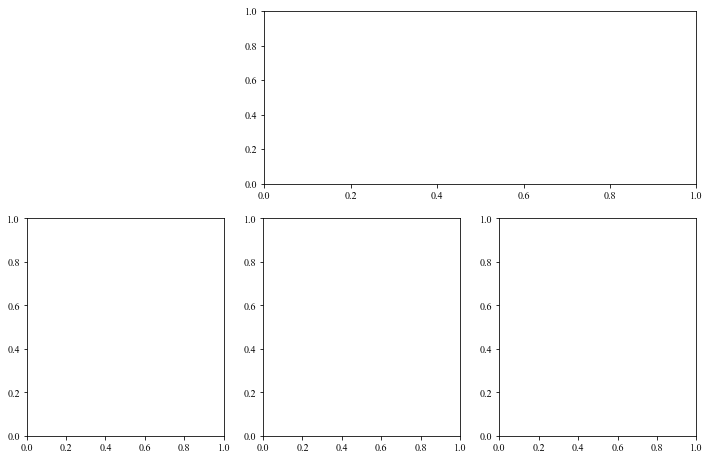

In [15]:
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(1,3,figsize = (12,4))
times = trE.times(reftime=evtime)
axp = fig.add_axes([0.4,1,0.5,0.6])
axp.vlines(x=picktime,ymin=-1,ymax=3,color='orange',ls='--')
axp.vlines(x=arr_time,ymin=-0.5,ymax=2.5,color='b',ls='--')
axp.plot(times,ZRT_R.data/pmax+1,'k',label='Z, R, T')
axp.plot(times,ZRT_T.data/pmax,'k')
axp.plot(times,ZRT_Z.data/pmax+2,'k')
axp.plot(times,LQT_Q.data/pmax+1,'r--',label='L, Q, T')
axp.plot(times,-1*(LQT_Q.data/pmax)+1,'green',ls=':',label='Q*-1')
axp.plot(times,LQT_T.data/pmax,'r--')
axp.plot(times,LQT_L.data/pmax+2,'r--')
axp.legend(loc=1)
axp.set_xlim(arr_time-50,arr_time+100)
axp.set_ylim(-0.5,2.5)
axp.set_yticks(np.arange(0,3,1))
axp.set_yticklabels(['T','R, Q','Z, L'],fontsize=13)

## write 2 sac and read again 2 add header 

In [13]:
yy = evtime.year
mmm = evtime.julday
hh = evtime.hour
mm = evtime.minute

savedir = f'SKSwaveform/{yy}{mmm}{hh}{mm}'
import os
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [226]:
trE.write(f'{savedir}/{net}.{sta}.{loc}.BHE',format='SAC')
trN.write(f'{savedir}/{net}.{sta}.{loc}.BHN',format='SAC')
trZ.write(f'{savedir}/{net}.{sta}.{loc}.BHZ',format='SAC')
ZRT_R.write(f'{savedir}/{net}.{sta}.{loc}.ZRT.BHR',format='SAC')
ZRT_T.write(f'{savedir}/{net}.{sta}.{loc}.ZRT.BHT',format='SAC')
LQT_L.write(f'{savedir}/{net}.{sta}.{loc}.LQT.BHL',format='SAC')
LQT_Q.write(f'{savedir}/{net}.{sta}.{loc}.LQT.BHQ',format='SAC')
LQT_T.write(f'{savedir}/{net}.{sta}.{loc}.LQT.BHT',format='SAC')

In [227]:
from obspy import read
st = read(f'{savedir}/*')

In [228]:
from obspy import read
st = read(f'{savedir}/*')
for tr in st:
    tr.stats.sac['evla'] = evlat
    tr.stats.sac['evlo'] = evlon
    tr.stats.sac['evdp'] = depth
    tr.stats.sac['mag'] = mag
    tr.stats.sac['stla'] = stlat
    tr.stats.sac['stlo'] = stlon
    tr.stats.sac['o'] = 0.000
    tr.stats.sac['t1'] = arr_time
    tr.stats.sac['dist']= epi_dist
    tr.stats.sac['az']= azi
    tr.stats.sac['baz']= baz
    tr.stats.sac['gcarc']= gac

In [229]:
st

8 Trace(s) in Stream:
II.KIV.00.BHE | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples
II.KIV.00.BHN | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples
II.KIV.00.BHZ | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples
II.KIV.00.BHL | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples
II.KIV.00.BHQ | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples
II.KIV.00.BHT | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples
II.KIV.00.BHR | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples
II.KIV.00.BHT | 2015-02-11T18:57:20.469500Z - 2015-02-11T19:27:20.369500Z | 10.0 Hz, 18000 samples

In [230]:
st[0].write(f'{savedir}/{net}.{sta}.{loc}.BHE',format='SAC')
st[1].write(f'{savedir}/{net}.{sta}.{loc}.BHN',format='SAC')
st[2].write(f'{savedir}/{net}.{sta}.{loc}.BHZ',format='SAC')
st[3].write(f'{savedir}/{net}.{sta}.{loc}.LQT.BHL',format='SAC')
st[4].write(f'{savedir}/{net}.{sta}.{loc}.LQT.BHQ',format='SAC')
st[5].write(f'{savedir}/{net}.{sta}.{loc}.LQT.BHT',format='SAC')
st[6].write(f'{savedir}/{net}.{sta}.{loc}.ZRT.BHR',format='SAC')
st[7].write(f'{savedir}/{net}.{sta}.{loc}.ZRT.BHT',format='SAC')


## SAC picking 

In [19]:
yy = evtime.year
mmm = evtime.julday
hh = evtime.hour
mm = evtime.minute

savedir = f'/Volumes/home/Research/STEP/SKSwaveform/{yy}{mmm}{hh}{mm}'

from obspy import read
SAC_st = read(f'{savedir}/*BHR')
picktime = SAC_st[0].stats.sac.t0

# IRIS = read('/Users/tong/Downloads/IRIS/*.miniseed')
# IRIS.filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
# IRIS.detrend('linear')
# IRIS.detrend('demean')
# Itime= IRIS[0].times(reftime=evtime)

# IL = IRIS.select(component='L')[0].copy()
# IQ = IRIS.select(component='Q')[0].copy()
# IT = IRIS.select(component='T')[0].copy()

Text(0.5, 0.45, 'Dist=119.39° b.p. 0.04-0.125Hz')

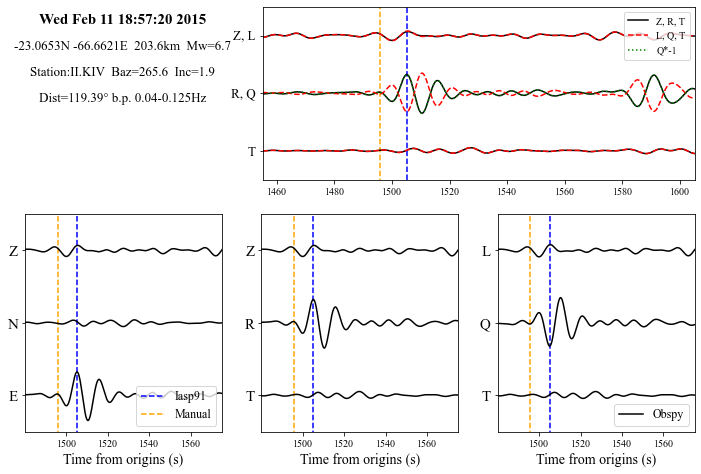

In [20]:
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(1,3,figsize = (12,4))
times = trE.times(reftime=evtime)
pmax = max(max(abs(trE.data)),max(abs(trN.data)),max(abs(trZ.data)))
ax[0].vlines(x=arr_time,ymin=-1,ymax=3,color='b',ls='--',label='Iasp91')
ax[0].vlines(x=picktime,ymin=-1,ymax=3,color='orange',ls='--',label='Manual')
ax[0].plot(times,trE.data/pmax,'k')
ax[0].plot(times,trN.data/pmax +1 ,'k')
ax[0].plot(times,trZ.data/pmax +2 ,'k')
ax[0].set_xlim(arr_time-25,arr_time+70)
ax[0].set_yticks(np.arange(0,3,1))
ax[0].set_yticklabels(['E','N','Z'],fontsize=15)
ax[0].set_ylim(-0.5,2.5)
ax[0].legend(fontsize=12,loc=4)
ax[0].set_xlabel('Time from origins (s)',fontsize=14)

ax[1].vlines(x=arr_time,ymin=-1,ymax=3,color='b',ls='--')
ax[1].vlines(x=picktime,ymin=-1,ymax=3,color='orange',ls='--')
ax[1].plot(times,ZRT_R.data/pmax+1,'k')
ax[1].plot(times,ZRT_T.data/pmax,'k')
ax[1].plot(times,ZRT_Z.data/pmax +2 ,'k')
ax[1].set_xlim(arr_time-25,arr_time+70)
ax[1].set_yticks(np.arange(0,3,1))
ax[1].set_yticklabels(['T','R','Z'],fontsize=15)
ax[1].set_ylim(-0.5,2.5)
ax[1].set_xlabel('Time from origins (s)',fontsize=14)

ax[2].vlines(x=arr_time,ymin=-1,ymax=3,color='b',ls='--')
ax[2].vlines(x=picktime,ymin=-1,ymax=3,color='orange',ls='--')
ax[2].plot(times,LQT_Q.data/pmax+1,'k',label='Obspy')
ax[2].plot(times,LQT_T.data/pmax,'k')
ax[2].plot(times,LQT_L.data/pmax+2,'k')
# ax[2].plot(Itime,IQ.data/pmax+1,'orchid',ls='--',label='IRIS')
# ax[2].plot(Itime,IT.data/pmax,'orchid',ls='--')
# ax[2].plot(Itime,IL.data/pmax+2,'orchid',ls='--')
ax[2].set_xlim(arr_time-25,arr_time+70)
ax[2].set_yticks(np.arange(0,3,1))
ax[2].set_yticklabels(['T','Q','L'],fontsize=15)
ax[2].set_ylim(-0.5,2.5)
ax[2].set_xlabel('Time from origins (s)',fontsize=14)
ax[2].legend(fontsize=12,loc=4)

axp = fig.add_axes([0.4,1,0.5,0.6])
axp.vlines(x=picktime,ymin=-1,ymax=3,color='orange',ls='--')
axp.vlines(x=arr_time,ymin=-0.5,ymax=2.5,color='b',ls='--')
axp.plot(times,ZRT_R.data/pmax+1,'k',label='Z, R, T')
axp.plot(times,ZRT_T.data/pmax,'k')
axp.plot(times,ZRT_Z.data/pmax+2,'k')
axp.plot(times,LQT_Q.data/pmax+1,'r--',label='L, Q, T')
axp.plot(times,-1*(LQT_Q.data/pmax)+1,'green',ls=':',label='Q*-1')
axp.plot(times,LQT_T.data/pmax,'r--')
axp.plot(times,LQT_L.data/pmax+2,'r--')
axp.legend(loc=1)
axp.set_xlim(arr_time-50,arr_time+100)
axp.set_ylim(-0.5,2.5)
axp.set_yticks(np.arange(0,3,1))
axp.set_yticklabels(['T','R, Q','Z, L'],fontsize=13)

axt = fig.add_axes([0.125,1,0.225,0.6])
axt.axis('off')
axt.text(0.5,0.9, f'{evtime.ctime()}', ha='center',weight='bold',fontsize=15)
axt.text(0.5,0.75, f'{evlat}N {evlon}E  {depth}km  Mw={mag}', ha='center',fontsize=13)
axt.text(0.5,0.6, f'Station:{net}.{sta}  Baz={round(baz,1)}  Inc={round(arr_inc,1)}', ha='center',fontsize=13)
axt.text(0.5,0.45, f'Dist={round(gac,2)}° b.p. {fmin}-{fmax}Hz', ha='center',fontsize=13)

# fig.savefig(f'{savedir}/{net}.{sta}.{loc}_LQTcomponent.png',dpi=150, bbox_inches='tight')